In [17]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
from dumbrain.lib.download import downloadAndUnzip
import matplotlib.pyplot as plt

# First, get the data

In [21]:
downloadAndUnzip( 'https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip', 'data/training/' )
downloadAndUnzip( 'https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip', 'data/validation/' )

9478144it [00:07, 1324315.92it/s]                             
100%|██████████| 4810560/4810560 [00:09<00:00, 493042.29it/s]
6471680it [00:11, 1406943.60it/s]                             
100%|██████████| 3371735/3371735 [00:07<00:00, 438596.71it/s]


0710_01.png 0710_05.png 0710_09.png 0710_13.png 0710_17.png
0710_02.png 0710_06.png 0710_10.png 0710_14.png 0710_18.png
0710_03.png 0710_07.png 0710_11.png 0710_15.png 0710_19.png
0710_04.png 0710_08.png 0710_12.png 0710_16.png 0710_20.png


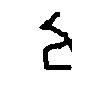